In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from Data import Data
from itertools import product
from sklearn.linear_model import LogisticRegression
from SegmentedModel import SegmentedModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)

In [2]:
data=Data()

## Get a baseline score with logistic regression

In [3]:
data.merge_dataset(exclude_columns=['sub_grade','Volatility'], type='dummy')
X_train, X_test, y_train, y_test = data.get_train_test_set()

model = LogisticRegression()
model.fit(X_train,y_train)
lr_score = model.score(X_test,y_test)
print lr_score

0.852392292704


## Get a baseline score with random forest

In [4]:
data.merge_dataset(exclude_columns=['sub_grade','Volatility'])
X_train, X_test, y_train, y_test = data.get_train_test_set()
model = RandomForestClassifier(n_estimators=400, n_jobs = -1)
model.fit(X_train, y_train)
rf_score = model.score(X_test, y_test)
print rf_score

0.916562026413


## Construct groups for segmentation

In [5]:
df = data.df

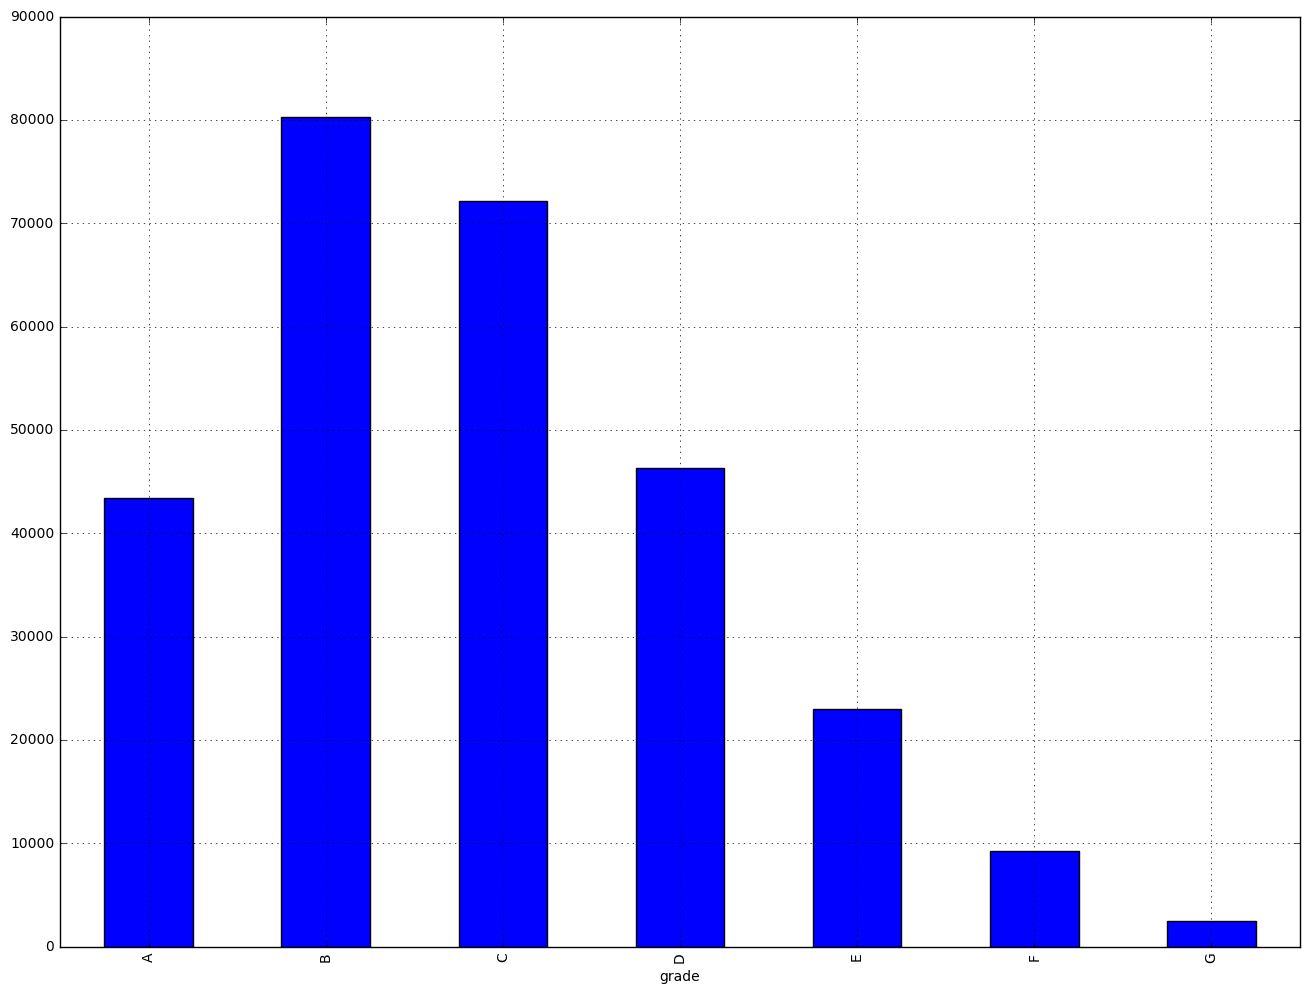

In [6]:
df.groupby('grade').size().plot(kind='bar').grid()

### Merge small groups to have groups of similar size

In [7]:
groups_grade = [('grade' , [['A'], ['B'], ['C'], ['D'], ['E', 'F', 'G']])]

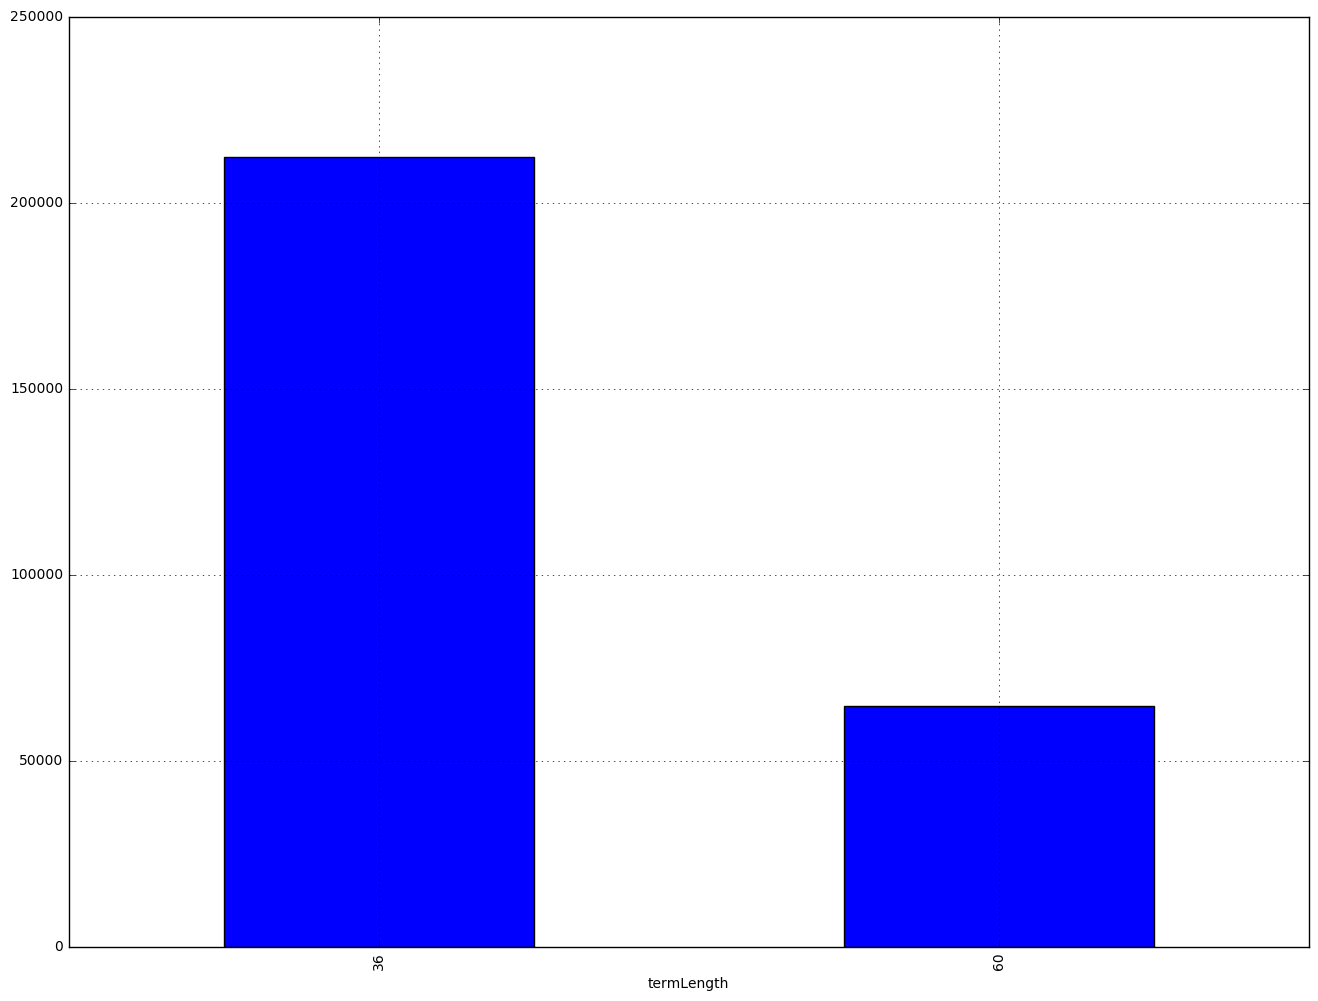

In [8]:
df.groupby('termLength').size().plot(kind='bar').grid()

In [9]:
groups_termLength =[('termLength', [[36], [60]])]

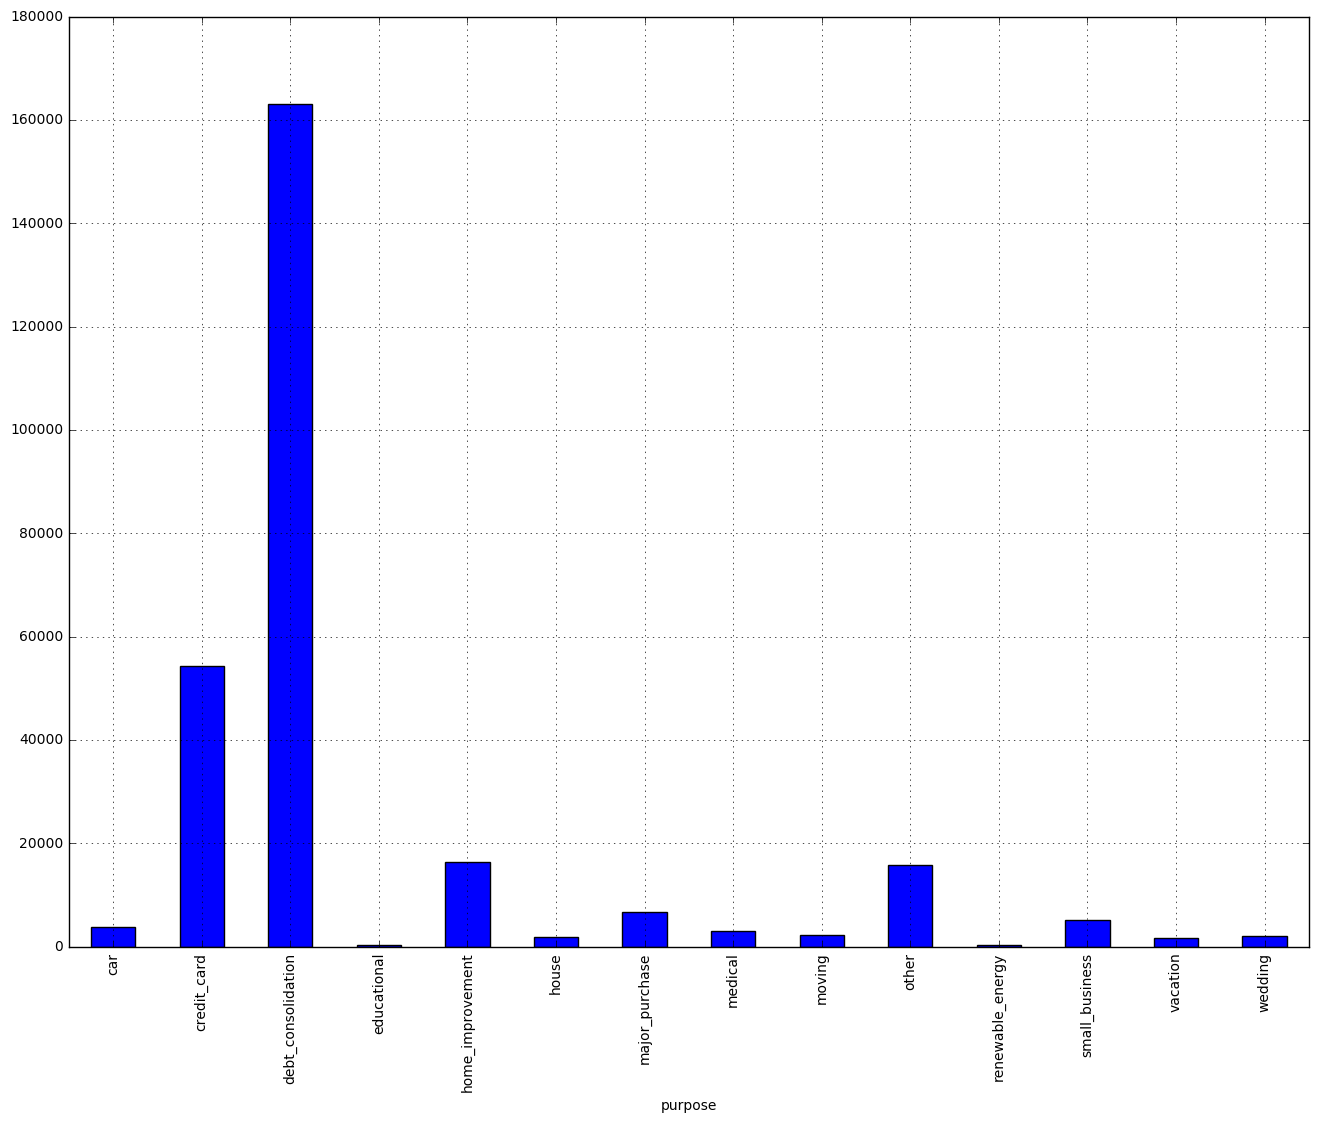

In [10]:
df.groupby('purpose').size().plot(kind='bar').grid()

In [11]:
groups_purpose = [('purpose',[['credit_card'],['debt_consolidation'],
 ['car',
 'small_business',
 'other',
 'wedding',
 'home_improvement',
 'major_purchase',
 'medical',
 'moving',
 'vacation',
 'house',
 'renewable_energy',
 'educational']])]

## Run segmented models with all groups and combinations of them

In [12]:
groups_list=[groups_grade,
             groups_purpose,
             groups_termLength,
             groups_grade+groups_purpose,
             groups_termLength+groups_grade,
             groups_purpose+groups_termLength,
             groups_grade+groups_purpose+groups_termLength]

### The segmented models can be built using the custom SegmentedModel class. The data can be segmented using multiple columns

In [18]:
group_trainscores = []
group_testscores = []
group_names = []
model = LogisticRegression()

for groups in groups_list:
    group_columns = list(zip(*groups)[0])
    group_names.append('\n'.join(group_columns))
    data.merge_dataset(exclude_columns=['sub_grade','Volatility']+group_columns, type='dummy')
    X_train, X_test, y_train, y_test = data.get_train_test_set()
    sm = SegmentedModel(df, groups, model)  
    sm.fit(X_train, y_train)
    group_trainscores.append(sm.score(X_train, y_train))
    group_testscores.append(sm.score(X_test, y_test))

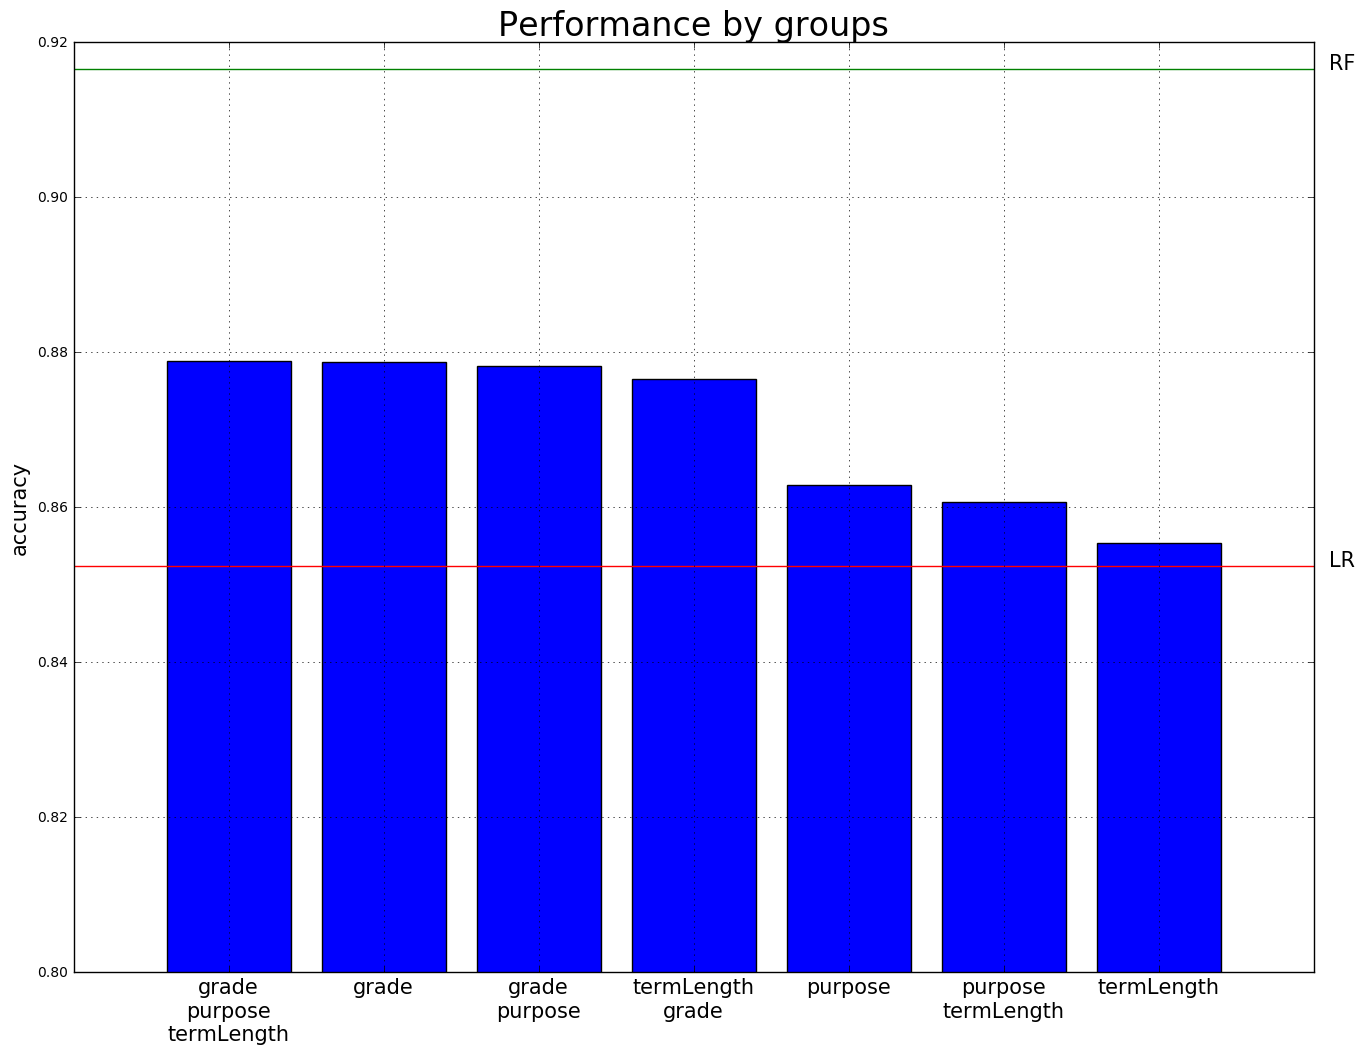

In [19]:
(group_testscores,group_names) = zip(*sorted(zip(group_testscores,group_names),reverse=True))
plt.bar(range(len(group_names)),group_testscores,align='center')
plt.xticks(range(len(group_names)),group_names, fontsize=15)    
plt.ylim((.8,0.92))
plt.grid()
plt.axhline(y=lr_score, color='r', linestyle='-')    
plt.axhline(y=rf_score, color='g', linestyle='-')    
plt.text(7.1,lr_score,'LR', fontsize=15)    
plt.text(7.1,rf_score,'RF', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.title('Performance by groups', fontsize='24')

In [28]:
print np.matrix(group_testscores).T

[[ 0.87880494]
 [ 0.87871834]
 [ 0.87822761]
 [ 0.87658223]
 [ 0.86284188]
 [ 0.86063361]
 [ 0.85530779]]


### Finally do a cross validation on the whole dataset to determine the most optimal grouping.

In [22]:
crossval_scores = []
group_names = []
model = LogisticRegression()

for groups in groups_list:
    group_columns = list(zip(*groups)[0])
    group_names.append('\n'.join(group_columns))
    data.merge_dataset(exclude_columns=['sub_grade','Volatility']+group_columns, type='dummy')
    X_train, X_test, y_train, y_test = data.get_train_test_set(test_size=0)
    sm = SegmentedModel(df, groups, model)  
    crossval_scores.append(cross_val_score(sm, X_train, y_train, cv=3, n_jobs=-1).mean())

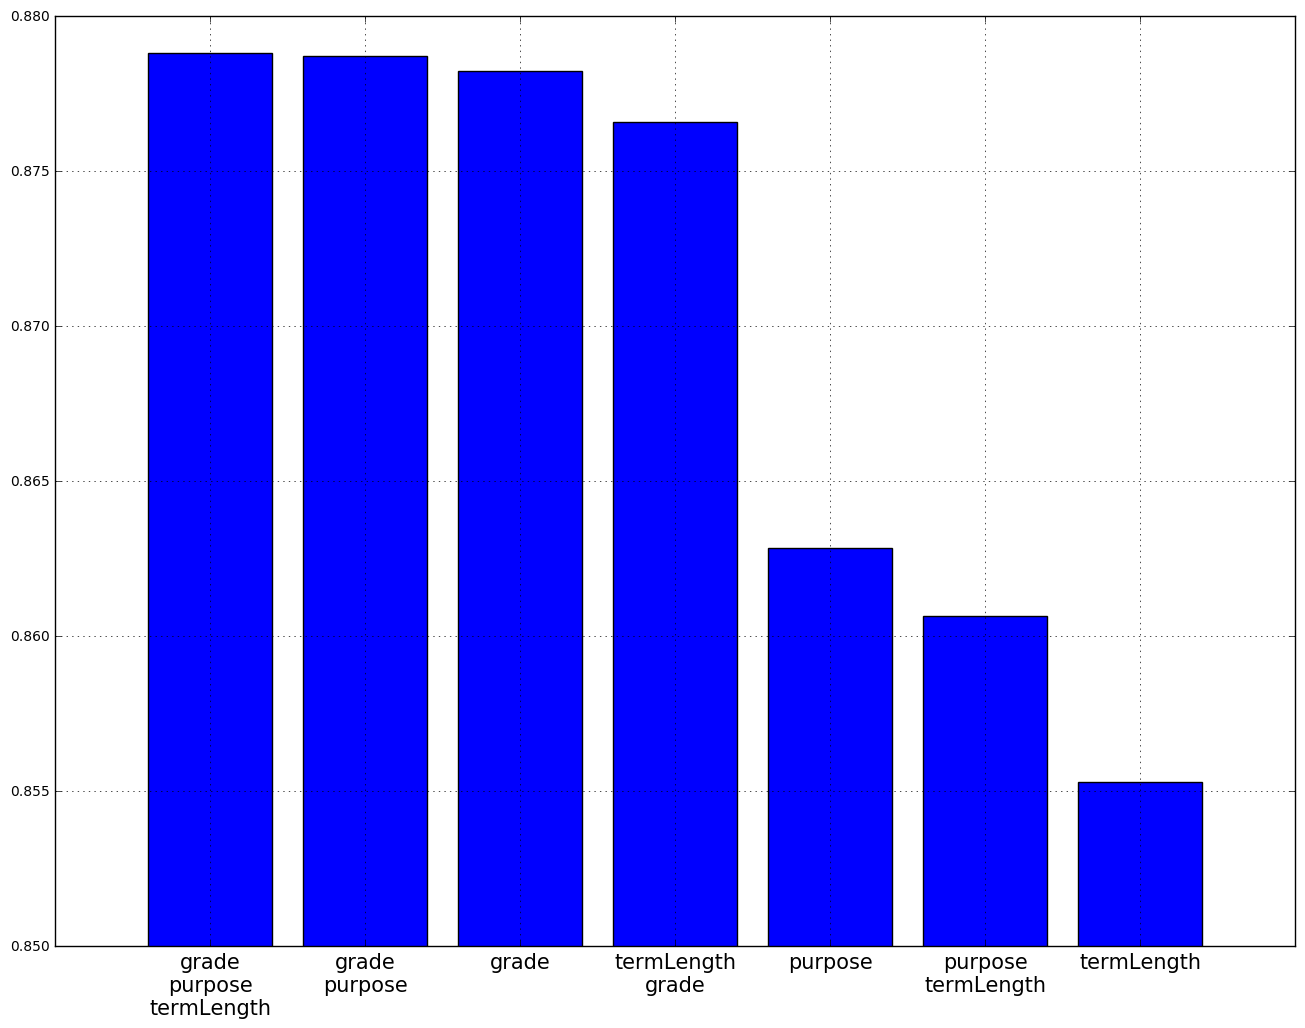

In [25]:
(crossval_scores,group_names) = zip(*sorted(zip(crossval_scores,group_names),reverse=True))
plt.bar(range(len(group_names)),group_testscores,align='center')
plt.xticks(range(len(group_names)),group_names, fontsize=15)    
plt.ylim((.85,0.88))
plt.grid()

In [27]:
print np.matrix(crossval_scores).T

[[ 0.87982969]
 [ 0.87885906]
 [ 0.87684203]
 [ 0.8766111 ]
 [ 0.86126506]
 [ 0.8577109 ]
 [ 0.85663924]]


## Conclusion
 
* All segmentation options gave better accuracy than the baseline logistic regression model. 
* For segmentation strategy 'grade' is a significant column. If one has to use logistic regression model, one should use segmentation based on the 'grade' column to achieve a significant performance gain.
* Columns 'termLength' and 'purpose' provide minor gains when segmentation is applied solely on these columns.
* Segmentation based on 3 columns at the same time, surprisingly, gave the best performance gain. The gain compared to 'grade' column, however, is miniscule, and can be ignored if somebody opts for a simpler model.